In [1]:
import os
os.chdir("/project/validating_attribution_techniques/")

In [2]:
!nvidia-smi

Wed Nov  1 20:13:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 22%   36C    P2              66W / 250W |   4265MiB / 11264MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus("2")
enable_web_access()

In [4]:
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from torchvision.models import resnet50, resnet18, vgg16, inception_v3
from torchvision.models.inception import Inception3


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


from commons.api.method.attribution import attribution


from commons.api.metric.compare_metrics import normalize, match_hist, normalize_map
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics

In [5]:
os.chdir("/project/validating_attribution_techniques/torchCAM")
from torchcam.methods.gradient import SmoothGradCAMpp, GradCAMpp, GradCAM, LayerCAM
from torchcam.methods.activation import ScoreCAM
from torchcam.utils import overlay_mask

In [6]:
os.chdir("/project/validating_attribution_techniques/")

In [7]:
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from io import BytesIO
from matplotlib.transforms import IdentityTransform

from PIL import Image
import json
from numpy import random
# import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image 
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [8]:

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [9]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [10]:
classes = get_imagenet_classes()

In [11]:
#Load all images
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)
masks = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/obj_masks_2_fixed.npy', allow_pickle=True)

In [12]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
# model_resnet50 = resnet50(pretrained=True).to(device).eval()
# model_resnet18 = resnet18(pretrained=True).to(device).eval()
# model_vgg = vgg16(pretrained=True).to(device).eval()
model_inception3 = inception_v3(pretrained=True).to(device).eval()
# model_resnet50.eval()

/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
target_layer = model_inception3.Mixed_7c.branch3x3dbl_3b

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Occlusion

## Loop

In [15]:
def initialize_metrics_values(techniques, metrics):
    metrics_values = {}
    for technique in techniques:
        metrics_values[technique] = {}
        for metric in metrics:
            metrics_values[technique][metric] = []
    return metrics_values

metrics_values = {
    "GradCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "ScoreCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "LayerCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "SmoothGradCAMpp": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    }
}

# Define the techniques and metrics you want to collect
techniques = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
metrics = ["sim", "cc", "nss", "auc", "emd", "ior"]

In [16]:
indexes = [i for i in range(0, 21)]

Image: 0 - Iteration: 0
Image: 0 - Iteration: 1
Image: 0 - Iteration: 2
Image: 0 - Iteration: 3
Image: 0 - Iteration: 4
Image: 0 - Iteration: 5
Image: 0 - Iteration: 6
Image: 0 - Iteration: 7
Image: 0 - Iteration: 8
Image: 0 - Iteration: 9
Image: 0 - Iteration: 10
Image: 0 - Iteration: 11
Image: 0 - Iteration: 12
Image: 0 - Iteration: 13
Image: 0 - Iteration: 14
Image: 0 - Iteration: 15
Image: 0 - Iteration: 16
Image: 0 - Iteration: 17
Image: 0 - Iteration: 18
Image: 0 - Iteration: 19
Image: 0 - Iteration: 20
Image: 0 - Iteration: 21
Image: 0 - Iteration: 22
Image: 0 - Iteration: 23
Image: 0 - Iteration: 24
Image: 0 - Iteration: 25
Image: 0 - Iteration: 26
Image: 0 - Iteration: 27
Image: 0 - Iteration: 28
Image: 0 - Iteration: 29
Image: 0 - Iteration: 30
Image: 0 - Iteration: 31
Image: 0 - Iteration: 32
Image: 0 - Iteration: 33
Image: 0 - Iteration: 34
Image: 0 - Iteration: 35
Image: 1 - Iteration: 0
Image: 1 - Iteration: 1
Image: 1 - Iteration: 2
Image: 1 - Iteration: 3
Image: 1 - Ite

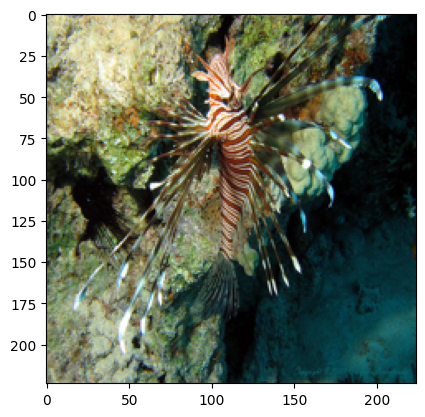

In [17]:

patch_size = 40

for img_idx in indexes:
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)
    # fig, axes = plt.subplots(ncols=2, nrows=1)
    fig, axes = plt.subplots(ncols=4, nrows=1)
    
    fig.set_figwidth(12)
    fig.set_layout_engine('tight')
    fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
    # fig.set_figheight(40)
    # Turn off the axis for each subplot
    for ax in axes:
        ax.axis('off')
    # Titles for each subplot
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    
    visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
    for i, ax in enumerate(axes):
        ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")
    plt.close(fig)
    gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)
    sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    
    # img_idx = 0
    gradcam = np.array([])
    scorecam = np.array([])
    smoothgradcampp = np.array([])
    layercam = np.array([])
    
    sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))
    
    rows = len(sample_occlu_imgs)
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    # print(rows)
    fig, axes = plt.subplots(ncols=8, nrows=rows)
    # Iterate through axes and turn off the axes for each subplot
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    for row in range(axes.shape[0]):
        for col in [0, 2, 4, 6]:
            # Add the title at the bottom of the image
            title = titles[col // 2]
            axes[row, col].text(0.5, -0.12, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[row, col].transAxes)
    
    fig.set_figheight(125)
    fig.set_figwidth(20)
    for row in range(axes.shape[0]):
        print(f"Image: {img_idx} - Iteration: {row}")
        # idx = row + img_idx
        idx = row
        # img = Image.open(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{row}.png")
        img = Image.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
        occlu_input_tensor = transform(img).to(device)
    
        pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50, occlu_input_tensor, "GradCAM", target_layer)
        pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet50, occlu_input_tensor, "ScoreCAM", target_layer)   
        pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet50, occlu_input_tensor, "SmoothGradCAMpp", target_layer)
        pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet50, occlu_input_tensor, "LayerCAM", target_layer)
        
        
        visualize_saliency_overlay(axes[row, 0], img, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
        visualize_saliency_overlay(axes[row, 2], img, pertubed_score_cam, pertubed_score_probs, pertubed_score_idx, classes);
        visualize_saliency_overlay(axes[row, 4], img, pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, pertubed_smoothgradpp_idx, classes);    
        visualize_saliency_overlay(axes[row, 6], img, pertubed_layer_cam, pertubed_layer_probs, pertubed_layer_idx, classes);
    
    # print(grad_cam)
    # print(pertubed_grad_cam)
        
        sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
        text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
    
        sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
        text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"
    
        sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
        text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"
    
        sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
        text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"
        
    #     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
        axes[row, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
        axes[row, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=10, dpi=200))
        axes[row, 5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=10, dpi=200))
        axes[row, 7].imshow(text_to_rgba(text_layer, color="blue", fontsize=10, dpi=200))

        for technique in techniques:
            for metric in metrics:
                if technique == "GradCAM":
                    calculated_value = locals()[metric.lower() + "_grad"]
                elif technique == "ScoreCAM":
                    calculated_value = locals()[metric.lower() + "_score"]
                elif technique == "SmoothGradCAMpp":
                    calculated_value = locals()[metric.lower() + "_smooth"]
                elif technique == "LayerCAM":
                    calculated_value = locals()[metric.lower() + "_layer"]
                # Append the calculated metric to the appropriate list
                metrics_values[technique][metric].append(calculated_value)

        for technique in techniques:
            for metric in metrics:
                metrics_values[technique][metric] = [float(value) for value in metrics_values[technique][metric]]
    
    
        gradcam = np.append(gradcam, pertubed_grad_cam)
        scorecam = np.append(scorecam, pertubed_score_cam)
        smoothgradcampp = np.append(smoothgradcampp, pertubed_smoothgradpp_cam)
        layercam = np.append(layercam, pertubed_layer_cam)
    
    
    
    # fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
    # fig.show()
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Occlusion_{patch_size}_{img_idx}.png")
    plt.close(fig)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/GradCAM_saliency_{patch_size}_idx_{img_idx}.npy", gradcam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/ScoreCAM_saliency_{patch_size}_idx_{img_idx}.npy", scorecam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/SmoothGradCAM_saliency_{patch_size}_idx_{img_idx}.npy", smoothgradcampp)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/saliency/LayerCAM_saliency_{patch_size}_idx_{img_idx}.npy", layercam)

    output_file = f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/metrics_{patch_size}_{img_idx}.json"
    if os.path.exists(output_file):
        os.remove(output_file)
    with open(output_file, 'w') as json_file:
        json.dump(metrics_values, json_file, indent=4)




# Summary

In [15]:
num_images = 100  # Number of images
num_patches = 9  # Number of patches per image
num_metrics = 6
cam_types = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

indexes = [i for i in range(0, 100)]
metrics_data = {cam_type: np.zeros((num_images, num_patches, num_metrics)) for cam_type in cam_types}

9
Image: 0 - Iteration: 0
Image: 0 - Iteration: 1
Image: 0 - Iteration: 2
Image: 0 - Iteration: 3
Image: 0 - Iteration: 4
Image: 0 - Iteration: 5
Image: 0 - Iteration: 6
Image: 0 - Iteration: 7
Image: 0 - Iteration: 8
9
Image: 1 - Iteration: 0
Image: 1 - Iteration: 1
Image: 1 - Iteration: 2
Image: 1 - Iteration: 3
Image: 1 - Iteration: 4
Image: 1 - Iteration: 5
Image: 1 - Iteration: 6
Image: 1 - Iteration: 7
Image: 1 - Iteration: 8
9
Image: 2 - Iteration: 0
Image: 2 - Iteration: 1
Image: 2 - Iteration: 2
Image: 2 - Iteration: 3
Image: 2 - Iteration: 4
Image: 2 - Iteration: 5
Image: 2 - Iteration: 6
Image: 2 - Iteration: 7
Image: 2 - Iteration: 8
9
Image: 3 - Iteration: 0
Image: 3 - Iteration: 1
Image: 3 - Iteration: 2
Image: 3 - Iteration: 3
Image: 3 - Iteration: 4
Image: 3 - Iteration: 5
Image: 3 - Iteration: 6
Image: 3 - Iteration: 7
Image: 3 - Iteration: 8
9
Image: 4 - Iteration: 0
Image: 4 - Iteration: 1
Image: 4 - Iteration: 2
Image: 4 - Iteration: 3
Image: 4 - Iteration: 4
Image:

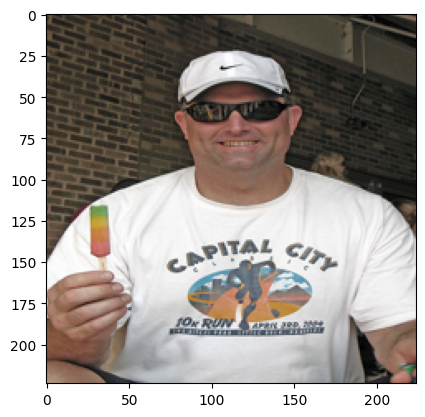

In [16]:


patch_size = 100
for img_idx in indexes:
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_inception3, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_inception3, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_inception3, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_inception3, input_tensor, "LayerCAM", target_layer)

    gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
    # np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)
    sample_occlu_imgs = np.array(gen_occlu_images)
    
    
    # sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))
    
    rows = len(sample_occlu_imgs)
    print(rows)
    
    for row in range(rows):
        print(f"Image: {img_idx} - Iteration: {row}")
        # idx = row + img_idx
        idx = row
        # img = Image.open(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Images_{patch_size}/Occlusion_{patch_size}_{row}.png")
        img = Image.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
        occlu_input_tensor = transform(img).to(device)
    
        pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_inception3, occlu_input_tensor, "GradCAM", target_layer)
        pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_inception3, occlu_input_tensor, "ScoreCAM", target_layer)   
        pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_inception3, occlu_input_tensor, "SmoothGradCAMpp", target_layer)
        pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_inception3, occlu_input_tensor, "LayerCAM", target_layer)
        
        
        sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    
        sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    
        sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    
        sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 

        metrics_data["GradCAM"][img_idx, row] = [sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad]
        metrics_data["ScoreCAM"][img_idx, row] = [sim_score, cc_score, nss_score, auc_score, emd_score, ior_score]
        metrics_data["SmoothGradCAMpp"][img_idx, row] = [sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth]
        metrics_data["LayerCAM"][img_idx, row] = [sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer]

    


summary_metrics = {}
for cam_type in cam_types:
    cam_metrics = metrics_data[cam_type]
    summary_metrics[cam_type] = {
        "mean": np.mean(cam_metrics, axis=(0, 1)),
        "median": np.median(cam_metrics, axis=(0, 1)),
        "min": np.min(cam_metrics, axis=(0, 1)),
        "std": np.std(cam_metrics, axis=(0, 1)),
        "max": np.max(cam_metrics, axis=(0, 1))
    }

# Save metrics_data
for cam_type, data in metrics_data.items():
    np.save(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/InceptionV3/Patch_100/{cam_type}_metrics_data.npy', data)

# Save summary_metrics
np.save(f'/project/validating_attribution_techniques/shardul/data/Doc/Tables/Occlusion/InceptionV3/Patch_100/summary_metrics.npy', summary_metrics)
        


